In [1]:
import urllib

import torch
import numpy as np
import mdtraj

from tqdm import tqdm
from matplotlib import pyplot as plt

from fab.utils.training import load_config
from experiments.make_flow.make_aldp_model import make_aldp_model

from openmmtools.testsystems import AlanineDipeptideVacuum

In [2]:
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
urllib.request.urlretrieve('https://huggingface.co/VincentStimper/fab/resolve/main/aldp/config.yaml', 'config.yaml')

('config.yaml', <http.client.HTTPMessage at 0x7f1a9aa8fe10>)

In [4]:
config = load_config('config.yaml')

config['data']['transform'] = '../' + config['data']['transform']

In [5]:
model = make_aldp_model(config, device)

In [6]:
urllib.request.urlretrieve('https://huggingface.co/VincentStimper/fab/resolve/main/aldp/model.pt', 'model.pt')

('model.pt', <http.client.HTTPMessage at 0x7f1a9a65f7d0>)

In [7]:
model.load('model.pt', map_location=device)

In [8]:
batch_size = 100
n_batches = 1000

x_list = []

with torch.no_grad():
    for _ in tqdm(range(n_batches)):
        z = model.flow.sample((100,))
        x, _ = model.target_distribution.coordinate_transform(z)
        x_list.append(x.cpu().numpy())

x = np.concatenate(x_list)

100%|██████████| 1000/1000 [01:49<00:00,  9.13it/s]


In [9]:
aldp = AlanineDipeptideVacuum()
topology = mdtraj.Topology.from_openmm(aldp.topology)
traj = mdtraj.Trajectory(x.reshape(-1, 22, 3), topology)

phi = mdtraj.compute_phi(traj)[1].reshape(-1)
psi = mdtraj.compute_psi(traj)[1].reshape(-1)

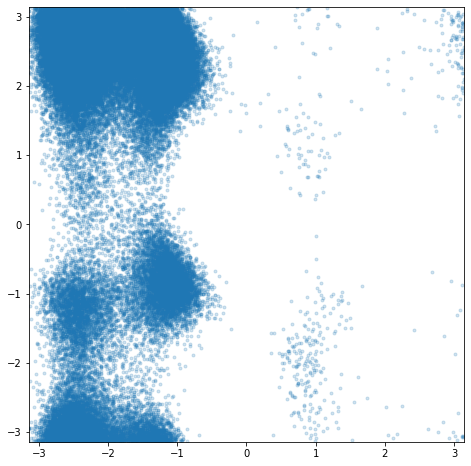

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(phi, psi, '.', alpha=0.2)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.gca().set_box_aspect(1)
plt.show()